#### Code for Figure 1 

### - Fig 2: Temperature comparison model vs obs
####        - Same year?
####        - Consider seasonality? Not at the moment, because comparison with seal data would be difficult. 
####        - Start making a map with both / Deep layer? 400m? More?

#### Get Adele's seal code from the vrtual machine. And then have to learn how to load the obs data in as .mat


In [33]:
%matplotlib inline

import cosima_cookbook as cc
import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as nc
import xarray as xr
import cmocean.cm as cmocean
from collections import OrderedDict
import cartopy.crs as ccrs
import matplotlib.path as mpath
import cftime
from glob import glob
import dask
import os
import datetime
import matplotlib.colors as col
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.colors as col
from scipy import interpolate


import logging
logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)

from dask.distributed import Client
# from cosima_cookbook import distributed as ccd

In [6]:
from dask.distributed import Client

print('starting distributed client...')
client = Client()
display(client)

starting distributed client...


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/42337/status,
Dashboard: /proxy/42337/status,Workers: 1
Total threads: 1,Total memory: 100.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:35567,Workers: 1
Dashboard: /proxy/42337/status,Total threads: 1
Started: Just now,Total memory: 100.00 GiB
Comm: tcp://127.0.0.1:36847,Total threads: 1
Dashboard: /proxy/39645/status,Memory: 100.00 GiB
Nanny: tcp://127.0.0.1:40913,


In [3]:
master_session = cc.database.create_session('/g/data/ik11/databases/cosima_master.db')
iaf_cycle3 = '01deg_jra55v140_iaf_cycle3'

first_year = '1958'
last_year = '2018'

start_time=first_year+'-01-01'
end_time=last_year+'-12-31'

time_period = str(int(start_time[:4]))+'-'+str(int(end_time[:4]))

### Load temperature data at determined depth

In [4]:
# load temperature data at 400m:

depth_slice = 400
# cut data for the extended area (Shack + Vincennes)
lat_slice  = slice(-75.5,-60)
lon_slice  = slice(-275, -230)

temp_400m = cc.querying.getvar(iaf_cycle3,'temp' , master_session,frequency='1 monthly',start_time=start_time, end_time=end_time) - 273.15
temp_400m = temp_400m.sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice).sel(st_ocean=depth_slice,method='nearest')
# load data
temp_400m = temp_400m.load()

KeyboardInterrupt: 

In [ ]:
#average for temperature 
temp_400m_avg = temp_400m.mean('time')

In [6]:
##calculating just MAM for 2012
first_year = '2012'
last_year = '2012'

start_time=first_year+'-01-01'
end_time=last_year+'-12-31'

time_period = str(int(start_time[:4]))+'-'+str(int(end_time[:4]))

In [7]:
# load temperature data at 400m:

depth_slice = 400
# cut data for the extended area (Shack + Vincennes)
lat_slice  = slice(-75.5,-60)
lon_slice  = slice(-275, -230)

temp_400m = cc.querying.getvar(iaf_cycle3,'temp' , master_session,frequency='1 monthly',start_time=start_time, end_time=end_time) - 273.15
temp_400m = temp_400m.sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice).sel(st_ocean=depth_slice,method='nearest')
# load data
temp_400m = temp_400m.load()

In [8]:
#just 2012
temp_400m_12 = temp_400m.groupby('time.season').mean('time')
temp_400m_12 = temp_400m_12.loc['MAM',:,:]

In [9]:
temp_400m_12

<xarray.DataArray 'temp' (yt_ocean: 357, xt_ocean: 450)>
array([[      nan,       nan,       nan, ...,       nan,       nan,
              nan],
       [      nan,       nan,       nan, ...,       nan,       nan,
              nan],
       [      nan,       nan,       nan, ...,       nan,       nan,
              nan],
       ...,
       [1.8801779, 1.7636923, 1.6320292, ..., 2.8411357, 2.8389385,
        2.8355305],
       [1.8870646, 1.7715353, 1.6370646, ..., 2.8441772, 2.8403728,
        2.8347473],
       [1.890686 , 1.7709452, 1.6367086, ..., 2.8459167, 2.8423462,
        2.8327637]], dtype=float32)
Coordinates:
  * xt_ocean  (xt_ocean) float64 -274.9 -274.8 -274.7 ... -230.2 -230.1 -230.0
  * yt_ocean  (yt_ocean) float64 -75.49 -75.45 -75.41 ... -60.15 -60.1 -60.05
    st_ocean  float64 383.0
    season    <U3 'MAM'

### Bathymetry

In [10]:
# import bathymetry and the land/ocean mask to add to plot:
ht = cc.querying.getvar(iaf_cycle3,'ht' , master_session,n=1)
ht = ht.sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice)
# create land mask from the bathymetry:
land_mask = np.squeeze(ht.values)*0
land_mask[np.isnan(land_mask)]=1
land_mask = np.where(land_mask==1,land_mask,np.nan)

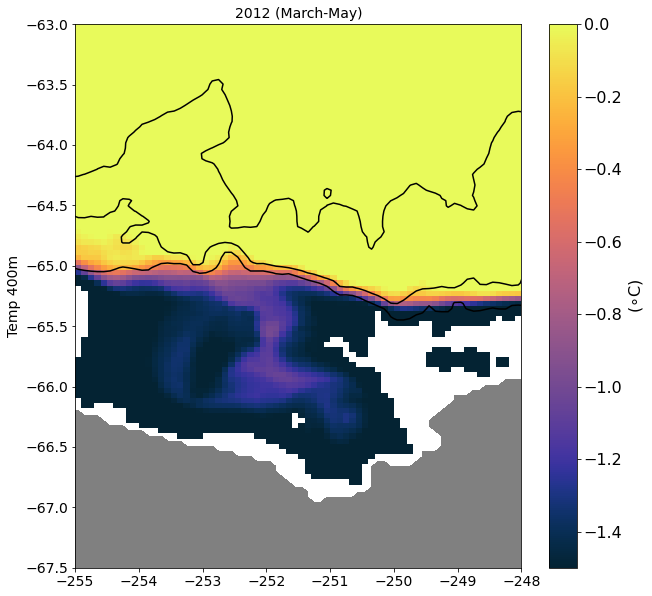

In [28]:
#Prepping variables to plot
fontsize=14

    #for nt in range(0,nframes):
fig=plt.figure(figsize=(22, 22))
fig.subplots_adjust(top=0.88)
    
ax0=plt.subplot(2,2,1)        
pc = plt.pcolormesh(temp_400m_12.xt_ocean,temp_400m_12.yt_ocean,
                        temp_400m_12, cmap = cmocean.thermal, 
                        vmin=-1.5,vmax=0)
plt.title('2012 (March-May)',fontsize=fontsize)
        #plot contours
plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,2000,3000],colors='k',linewidth=.5)
        # plot the land:
plt.contourf(ht.xt_ocean,ht.yt_ocean,land_mask,colors='grey')
        # labels etc:
        #plt.xlabel('Longitude',fontsize=fontsize)
plt.ylabel('Temp 400m',fontsize=fontsize)
plt.tick_params(labelsize=fontsize)
        #lim
plt.ylim((-67.5, -63))
plt.xlim((-255, -248))
        # colorbar:
cbar=plt.colorbar(pc,orientation='vertical',extend='neither')
cbar.ax.locator_params(nbins=8)
cbar.set_label(r'($\circ$C)', fontsize = 16,labelpad=5)
cbar.ax.tick_params(labelsize=16)

In [12]:
import scipy.io
import pandas as pd
annots = scipy.io.loadmat('/g/data/jk72/ns3783/seal_data/West_Shack_VB_Totten_triado.mat')

In [13]:
annots.keys()

dict_keys(['__header__', '__version__', '__globals__', 'ND_vcb', 'ans', 'day_vcb', 'hr_vcb', 'lat_vcb', 'lon_vcb', 'max_id', 'mi_vcb', 'mth_vcb', 'pres_adj_err_vcb', 'pres_adj_qc_vcb', 'pres_adj_vcb', 'pres_vcb', 'sal_adj_err_vcb', 'sal_adj_qc_vcb', 'sal_adj_vcb', 'sal_vcb', 'seal_vcb', 'sec_vcb', 'temp_adj_qc_vcb', 'temp_adj_vcb', 'temp_pot_vcb', 'temp_vcb', 'yr_vcb'])

In [14]:
type(annots['sal_adj_vcb']),annots['sal_adj_vcb'].shape

(numpy.ndarray, (30, 12533))

In [19]:
sal=annots['sal_adj_vcb'];
temp=annots['temp_pot_vcb'];
lon=annots['lon_vcb'];
lat=annots['lat_vcb'];
pres=annots['pres_adj_vcb']

In [26]:
lon

array([[89.6951, 89.9609, 90.069 , ..., 95.0615, 94.8006, 94.2054]])

TypeError: Dimensions of C (30, 12533) are incompatible with X (12533) and/or Y (1); see help(pcolormesh)

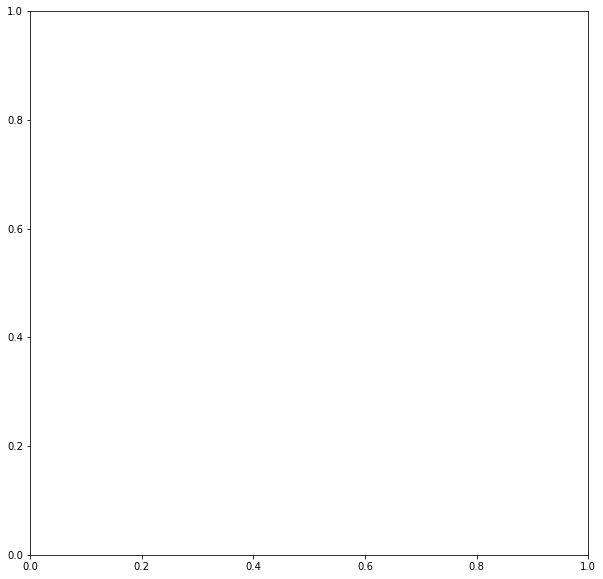

In [24]:
#Prepping variables to plot
fontsize=14

    #for nt in range(0,nframes):
fig=plt.figure(figsize=(22, 22))
fig.subplots_adjust(top=0.88)
    
ax0=plt.subplot(2,2,1)        
pc = plt.pcolormesh(lon,lat,temp, cmap = cmocean.thermal, 
                        vmin=-1.5,vmax=1.5)

In [23]:
pres[0,0]

4.0

In [53]:
type(annots['sal_adj_vcb'][0][0]),annots['sal_adj_vcb'][0][0].shape

(numpy.float64, ())

In [59]:
print(annots['sal_adj_vcb'][0][0])

34.038002014160156


In [60]:
annots['sal_adj_vcb'][0][0]['bbox_x1'], annots['sal_adj_vcb'][0][0]['fname']

IndexError: invalid index to scalar variable.

#### LOAD SEALS 

In [8]:
master_session = cc.database.create_session('/g/data/ik11/databases/cosima_master.db')
control = '01deg_jra55v13_ryf9091'

start_time='2150-01-01'
end_time='2159-12-31'

lon_slice  = slice(-255, -247)
lat_slice  = slice(-75.5,-60)

In [9]:
# topography data:
ht = cc.querying.getvar(control,'ht' , master_session,n=1)
ht = ht.sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice)
land_mask = np.squeeze(ht.values)*0
land_mask[np.isnan(land_mask)] = 1
land_mask = np.where(land_mask==1,land_mask,np.nan)

# bottom cell indices:
kmt = cc.querying.getvar(control,'kmt',master_session, n=-1)
kmt = kmt.sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice)
kmt = kmt.fillna(1.0).astype(int) - 1
kmt.load()

fontsize=16

## Get model grid data and temperature climatology:

In [10]:
# for comparing seal data to IAF:
iaf = '01deg_jra55v140_iaf_cycle3'

start_time='2012-01-01'
end_time='2012-12-31'

temp_con = cc.querying.getvar(iaf,'temp', master_session,frequency='1 monthly',start_time=start_time, end_time=end_time) - 273.15
temp_con = temp_con.sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice)                          
#temp_con = temp_con.sel(time=slice(start_time,end_time)).groupby('time.month').mean('time')
temp_con = temp_con[:,:50,:,:]
temp_con = temp_con.load()

In [11]:
xt_ocean = temp_con.xt_ocean
yt_ocean = temp_con.yt_ocean
st_ocean = temp_con.st_ocean

In [12]:
# Shelf mask

# Note this is on the t grid
contour_file = np.load('/g/data/ik11/grids/Antarctic_slope_contour_1000m.npz')
shelf_mask = contour_file['contour_masked_above']
yt_ocean = contour_file['yt_ocean']
xt_ocean = contour_file['xt_ocean']
shelf_mask[np.where(shelf_mask!=0)] = np.nan
shelf_mask = shelf_mask+1
shelf_map = np.nan_to_num(shelf_mask)
shelf_mask = xr.DataArray(shelf_mask, coords = [('yt_ocean', yt_ocean), ('xt_ocean', xt_ocean)])
shelf_map = xr.DataArray(shelf_map, coords = [('yt_ocean', yt_ocean), ('xt_ocean', xt_ocean)])
shelf_map = shelf_map.sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice)

## Select out profiles in correct region:

In [126]:
%%time

# do some testing to see which seal data is in the right region:
# Need to consider profiles from Brazil, Germany, UK, USA
# I think the interpolated data is fine to use here, because I only want profiles < 1000m.

path2files   = '/g/data/jk72/ns3783/seal_data/'
FileList = glob(path2files+'*.nc')
FileList.sort()


WAP_FileList = []
nprofiles= []
for file in FileList:
    # open all profiles for this seal:
    profile_data = xr.open_dataset(file)
    lat = profile_data.LATITUDE
    lon = profile_data.LONGITUDE
    # check if in Vincennes Bay Box // HERE IT SHOULD BE WITH THE LAT/LON FROM THE DATA GRID, RIGHT?
    WAP_box=lat.where(lon>104).where(lon<114).where(lat<-60).dropna(dim='N_PROF')
    s=np.shape(WAP_box) #NRS
    if len(WAP_box)>0:
        WAP_FileList += [file]
        nprofiles += [s] #NRS


CPU times: user 7.14 s, sys: 607 ms, total: 7.75 s
Wall time: 8.86 s


In [129]:
a = np.sum(nprofiles) 

In [130]:
a

7647

In [152]:
%%time

# Now go through the profiles in the WAP box and select out all profiles on the shelf:

nprofiles = a; # NRS I calculated the number here by changing your previous loop. there I store the number of profiles of each seal and sum them on the next cell. 
ndepth = 1000  # NRS I got the product that is interpolated, because I read your code and thought that was what you were using. But not sure where your 22 value for ndepth came from. 
temp = np.zeros((nprofiles,ndepth))
pres = np.zeros((nprofiles,ndepth))
lon_obs = np.zeros((nprofiles))
lat_obs = np.zeros((nprofiles))
date = []
profile_count = 0

for file in WAP_FileList:
    # open all profiles for this seal:
    profile_data = xr.open_dataset(file)
    lat = profile_data.LATITUDE
    lon = profile_data.LONGITUDE
    ###### I MADE A LITTLE CHANGE HERE, because I had to adjust the data to the model grid. Is that right? NRS 
    lon = lon - 360
    # go through each profile and find nearest model grid point:
    for profile in range(len(lat)):
        # NOTE THAT LONGITUDE IS NOT ADJUSTED FOR THE MODEL RANGE HERE, BECAUSE RANGE ON PENINSULA IS OK
        # BUT THIS WILL NOT WORK ELSEWHERE!!
        on_shelf = shelf_map.sel(xt_ocean=lon[profile],method='nearest').sel(yt_ocean=lat[profile],method='nearest')
        if on_shelf>0:
            # check temp has at least 2 data points:
            temp_profile = profile_data.TEMP_ADJUSTED[profile]
            if len(np.where((temp_profile!=0.)&(~np.isnan(temp_profile)))[0]) > 2:
                # check the dive reached at least 200 dbar:
                pres_profile = profile_data.PRES_ADJUSTED[profile]
                if pres_profile.max() > 200:
                    date = np.append(date,profile_data.JULD[profile])
                    # save profile:
                    lat_obs[profile_count] = lat[profile]
                    lon_obs[profile_count] = lon[profile]
                    # find depth of profile:
                    nlevels = len(profile_data.PRES_ADJUSTED[profile])
                    temp[profile_count,:nlevels] = temp_profile
                    pres[profile_count,:nlevels] = pres_profile
                    profile_count += 1

CPU times: user 49.2 s, sys: 1.54 s, total: 50.8 s
Wall time: 55.3 s


In [153]:
np.shape(temp)

(7647, 1000)

## Interpolate MEOP profiles onto model depth grid:
Adele mentions on her code that "At some point I should check what the error in assuming 1 dbar = 1 m"

In [154]:
%%time
# Only care about on shelf, so just do top 50 levels:
temp_interp = np.zeros((nprofiles,50))



CPU times: user 1.95 ms, sys: 0 ns, total: 1.95 ms
Wall time: 6.33 ms


In [156]:
np.shape(temp_interp)

(7647, 50)

In [157]:
for profile in range(nprofiles):
    # select out available pressure range of data:
    pres_idx = [pres[profile,:]>0]
  #  temp_profile = temp[profile,:][pres[profile,:]>0]

In [178]:
np.max(temp)

nan

In [182]:
pres_profile = pres[pres>0]

In [186]:
temp_profile = temp[pres>0]

In [198]:
a=pres[profile,:]

In [199]:
np.shape(a)

(1000,)

In [188]:
np.max(temp_profile)

nan

In [192]:
np.shape(pres)

(7647, 1000)

In [215]:
for profile in range(nprofiles):
    # select out available pressure range of data:
    p=pres[profile,:];
    t=temp[profile,:];
    pres_profile = p[p>0]
    temp_profile = t[p>0]
    # also remove missing temperature points:
#    temp_profile_adj = temp_profile[temp_profile!=0]
#    pres_profile_adj = pres_profile[temp_profile!=0]
#    f = interpolate.interp1d(pres_profile,temp_profile,bounds_error=False)

ValueError: cannot reshape array of size 0 into shape (0,newaxis)

In [216]:
np.size(t)

1000

In [ ]:
%%time
# Only care about on shelf, so just do top 50 levels:
temp_interp = np.zeros((nprofiles,50))

for profile in range(nprofiles):
    # select out available pressure range of data:
    pres_profile = pres[pres[profile,:]>0]
    temp_profile = temp[pres[profile,:]>0]
    # also remove missing temperature points:
    temp_profile_adj = temp_profile[temp_profile!=0]
    pres_profile_adj = pres_profile[temp_profile!=0]
    
    f = interpolate.interp1d(pres_profile,temp_profile,bounds_error=False)
    temp_interp[profile,:] = f(st_ocean)

In [218]:
np.nanmax(t)

0.0